In [2]:
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import pickle
from constants import *
from locale import atof, setlocale, LC_NUMERIC
plt.style.use(home_dir+'stylefile.mplstyle')
setlocale(LC_NUMERIC,'')
atof('123,123')


123123.0

In [ ]:
meta = pd.read_csv(pe_data_dir + 'metadata.csv')
meta1 = meta[['Gauge_ID','Latitude','Longitude','Fire_Year']]
meta2 = meta[['Gauge_ID.1','Latitude.1','Longitude.1','Fire_Year.1']]
meta2.columns = meta1.columns 
md = meta1.append(meta2)
md.index = range(0,len(md))
md = md[0:179]
tmp = []
for i in md['Gauge_ID']:
    id = str((int(i)))
    if len(id)<8:
        fullid = '0' + id
    else:
        fullid = id
    tmp.append(fullid)
md['Gauge_ID'] = tmp
with open(pe_data_dir + 'streamflow_metadata.pickle', 'wb') as handle:
    pickle.dump(md, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(pe_data_dir + 'streamflow_metadata.pickle', 'rb') as handle:
    md = pickle.load(handle)


In [3]:
with open(pe_data_dir + 'streamflow_metadata.pickle', 'rb') as handle:
    md = pickle.load(handle)


In [4]:
def get_details (site, start_date, end_date):
    url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?site={site}&startDT={start}&endDT={end}&parameterCD=00060&format=json'.format(site=site, start=start_date, end=end_date)

    req = requests.get(url)

    if req.status_code != 200 :
        print('request has returned with status {}'.format(req.status_code))
        return

    resp_data = json.loads(req.text)
    # I need the data itself, the bad value, unit, variable description and name
    # discard unneeded data
    resp_data = resp_data['value']['timeSeries'][0]

    # begin building what I'll return
    good_data = {}
    # I will use this to keep track of any problems that I don't want to stop on
    good_data['problems'] = []

    # get site number (I want to be sure they match)
    site_num = resp_data['sourceInfo']['siteCode'][0]['value']
    good_data['site_num'] = site_num
    if site_num != site :
        good_data['problems'].append('Site number in response {} does not match given {}'.format(site_num, site))

    # get site name
    good_data['siteName'] = resp_data['sourceInfo']['siteName']

    # get huc code
    huc_code = next(i for i in resp_data['sourceInfo']['siteProperty'] if i['name'] == 'hucCd')
    good_data['huc_code'] = huc_code['value']

    # get no-data value
    no_value = resp_data['variable']['noDataValue']

    # get variable description
    var_description = resp_data['variable']['variableDescription']
    good_data['var_description'] = var_description

    # get datapoints
    good_data['series'] = []
    good_data['value'] = []
    good_data['datetime'] = []
    for item in resp_data['values'][0]['value'] :
        if item['value'] == no_value:
            item['value'] = None
        del item['qualifiers']
        good_data['series'].append(item)
        good_data['value'].append(item['value'])
        good_data['datetime'].append(item['dateTime'])
    


    ## below this point is temperature
    '''url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?site={site}&startDT={start}&endDT={end}&parameterCD=00010&format=json'.format(site=site, start=start_date, end=end_date)

    req = requests.get(url)

    if req.status_code != 200 :
        print('request has returned with status {}'.format(req.status_code))
        return

    resp_data = json.loads(req.text)
    # I need the data itself, the bad value, unit, variable description and name
    # discard unneeded data
    resp_data = resp_data['value']['timeSeries'][0]

    # begin building what I'll return
    good_data_t = {}
    # I will use this to keep track of any problems that I don't want to stop on
    good_data_t['problems'] = []

    # get site number (I want to be sure they match)
    site_num = resp_data['sourceInfo']['siteCode'][0]['value']
    good_data_t['site_num'] = site_num
    if site_num != site :
        good_data_t['problems'].append('Site number in response {} does not match given {}'.format(site_num, site))

    # get site name
    good_data_t['siteName'] = resp_data['sourceInfo']['siteName']

    # get huc code
    huc_code = next(i for i in resp_data['sourceInfo']['siteProperty'] if i['name'] == 'hucCd')
    good_data_t['huc_code'] = huc_code['value']

    # get no-data value
    no_value = resp_data['variable']['noDataValue']

    # get variable description
    var_description = resp_data['variable']['variableDescription']
    good_data_t['var_description'] = var_description

    # get datapoints
    good_data_t['series'] = []
    good_data_t['value'] = []
    good_data_t['datetime'] = []
    for item in resp_data['values'][0]['value'] :
        if item['value'] == no_value:
            item['value'] = None
        del item['qualifiers']
        good_data_t['series'].append(item)
        good_data_t['value'].append(item['value'])
        good_data_t['datetime'].append(item['dateTime'])

    df = pd.DataFrame(data = good_data['value'],index = good_data['datetime'],columns=['streamflow'])
    df_t = pd.DataFrame(data = good_data_t['value'], index = good_data_t['datetime'],columns = ['temperature'])

    df_dt = df.merge(df_t,left_index=True,right_index=True)'''
    
    return good_data# , df_dt

In [92]:
url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?site={site}&startDT={start}&endDT={end}&parameterCD=00060&format=json'.format(site=site, start=start_date, end=end_date)

req = requests.get(url)

resp_data = json.loads(req.text)
# I need the data itself, the bad value, unit, variable description and name
# discard unneeded data
resp_data = resp_data['value']['timeSeries'][0]

IndexError: list index out of range

In [9]:
for i in range(79,len(md)):
    site = md['Gauge_ID'][i]
    fy = md['Fire_Year'][i]
    start_date = '1900-01-01'
    end_date = '2022-08-01'
    
    try:
        data = get_details(site=site, start_date=start_date, end_date=end_date)
        df = {'site': site,
        'streamflow':data,
        'fireyear': fy}
    except:
        print('no data ' + str(site))
        df = {'site': site}


    with open(pe_data_dir + 'streamflow'+ str(site)+'.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)




no data 11230500
no data 11315000
no data 11316800
no data 11367500
no data 11427700
no data 11478500


In [85]:
data = get_details(site=site, start_date=start_date, end_date=end_date)


In [ ]:
with open(pe_data_dir + 'gaged_basins.pickle', 'rb') as handle:
    alldata = pickle.load(handle)

for i in range(97,len(md)):
    site = md['Gauge_ID'][i]
    fy = md['Fire_Year'][i]
    start_date = '1900-01-01'
    end_date = '2022-08-01'
    data = get_details (site=site, start_date=start_date, end_date=end_date)
    if(~np.isnan(fy)): # how to treat the areas that are burned
        print('burned')
    else:
        print('unburned')
    
    df = {'site': site,
        'streamflow':data,
        'fireyear': fy}
    
    with open(pe_data_dir + 'streamflow'+ str(site)+'.pickle', 'wb') as handle:
        pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)




In [47]:
i

16

In [187]:
site = 'K2P'
start_date = '2021-04-12'
end_date = '2022-04-12'
url = 'https://cdec.water.ca.gov/dynamicapp/QueryDaily?s={site}&start={start}&end={end}'.format(site=site, start=start_date, end=end_date)
req = requests.get(url)
url
# url ='https://cdec.water.ca.gov/dynamicapp/QueryDaily?s=K2P&end=2022-04-12&start=2021-04-12&format=json'
req = requests.get(url)

from bs4 import BeautifulSoup

page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
title = soup.title.text # gets you the text of the <title>(...)</title>
tab = soup.table
date = []
outflow_af = []
dis_cfs = []
for val in tab.contents[3].text.split('\n'):
    if(val!=''):
        print(val)

03/13/2022
2,669 
1,346 
03/14/2022
2,825 
1,424 
03/15/2022
2,176 
1,097 
03/16/2022
1,659 
836 
03/17/2022
2,738 
1,380 
03/18/2022
3,002 
1,514 
03/19/2022
4,032 
2,033 
03/20/2022
2,777 
1,400 
03/21/2022
2,290 
1,154 
03/22/2022
2,048 
1,032 
03/23/2022
3,412 
1,720 
03/24/2022
3,270 
1,649 
03/25/2022
3,522 
1,776 
03/26/2022
3,236 
1,632 
03/27/2022
1,962 
989 
03/28/2022
3,141 
1,584 
03/29/2022
3,610 
1,820 
03/30/2022
5,119 
2,581 
03/31/2022
4,798 
2,419 
04/01/2022
5,435 
2,740 
04/02/2022
4,929 
2,485 
04/03/2022
4,722 
2,380 
04/04/2022
        --
        --
04/05/2022
        --
        --
04/06/2022
        --
        --
04/07/2022
        --
        --
04/08/2022
        --
        --
04/09/2022
        --
        --
04/10/2022
        --
        --
04/11/2022
        --
        --
04/12/2022
        --
        --


In [188]:
url

'https://cdec.water.ca.gov/dynamicapp/QueryDaily?s=K2P&start=2021-04-12&end=2022-04-12'

In [189]:
data = []
for val in tab.contents[3].text.split('\n'):
    if(val!=''):
            data.append(val)
mat = np.reshape(data,(31,3))



In [196]:
#date = mat[:,0]
#outflow_af = [float(val) for val in mat[:,1]]
#dis_cfs = [float(val) for val in mat[:,2]]
#dts = [dt.datetime.strptime(d, '%m/%d/%Y') for d in date]
url

'https://cdec.water.ca.gov/dynamicapp/QueryDaily?s=K2P&start=2021-04-12&end=2022-04-12'

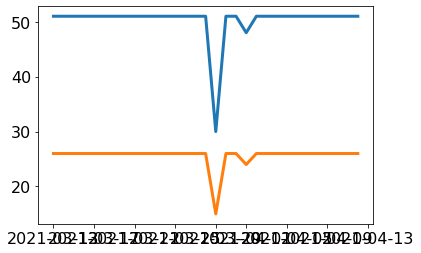

In [ ]:
fig,ax=plt.subplots()
ax.plot(dts,outflow_af)
ax.plot(dts,dis_cfs)

In [ ]:
## currently coded for discharge and outflow, edit to change variable types
def get_cdec_details (site, start_date, end_date):
    setlocale(LC_NUMERIC,'')
    sdt = dt.datetime.strptime(start_date,'%Y-%m-%d')
    edt = dt.datetime.strptime(end_date,'%Y-%m-%d')
    span = (edt-sdt).days
    # url = 'https://cdec.water.ca.gov/dynamicapp/QueryDaily?s={site}&start={start}&end={end}'.format(site=site, start=start_date, end=end_date)
    url = 'https://cdec.water.ca.gov/dynamicapp/QueryDaily?s={site}&end={end}&span={span}'.format(site=site, start=start_date, end=end_date, span = span)

    page = requests.get(url)

    if page.status_code != 200 :
        print('request has returned with status {}'.format(req.status_code))
        return

    soup = BeautifulSoup(page.content, 'html.parser')
    title = soup.title.text # gets you the text of the <title>(...)</title>
    tab = soup.table

    data = []
    for val in tab.contents[3].text.split('\n'):
        if(val!=''):
            data.append(val)
    size = (len(data)/3)
    mat = np.reshape(data,(int(size),3))
    
    outflow_af =[]
    dis_cfs=[]
    date = mat[:,0]
    for i in range(len(date)):
        tmp = mat[i,1]
        try:
            outflow_af.append(atof(tmp))
        except:
            outflow_af.append(np.nan)
            #continue
        tmp = mat[i,2]
        try:
            dis_cfs.append(atof(tmp))
        except:
            dis_cfs.append(np.nan)
            #continue


    
    #outflow_af = [atof(val) for val in mat[:,1]]
    #dis_cfs = [atof(val) for val in mat[:,2]]
    dts = [dt.datetime.strptime(d, '%m/%d/%Y') for d in date]


    # begin building what I'll return
    good_data = {}
    # I will use this to keep track of any problems that I don't want to stop on
    good_data['problems'] = []

    # get site name
    good_data['siteName'] = title
    good_data['date'] = dts
    good_data['outflow_af'] = outflow_af
    good_data['dis_cfs'] = dis_cfs

    return good_data

In [193]:
site = 'K2P'
start_date = '2021-04-12'
end_date = '2022-04-12'
data = get_cdec_details(site,start_date,end_date)

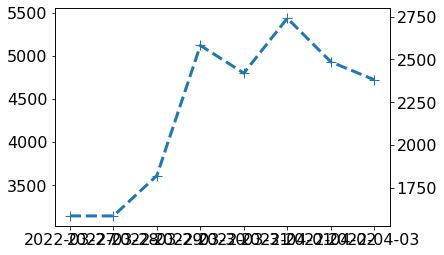

In [194]:
fig,ax=plt.subplots()
ax.plot(data['date'],data['outflow_af'],'+')
ax2 = ax.twinx()
ax2.plot(data['date'],data['dis_cfs'],'--')

In [ ]:
def get_details (site, start_date, end_date):
    url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?site={site}&startDT={start}&endDT={end}&parameterCD=00060&format=json'.format(site=site, start=start_date, end=end_date)

    req = requests.get(url)

    if req.status_code != 200 :
        print('request has returned with status {}'.format(req.status_code))
        return

    resp_data = json.loads(req.text)
    # I need the data itself, the bad value, unit, variable description and name
    # discard unneeded data
    resp_data = resp_data['value']['timeSeries'][0]

    # begin building what I'll return
    good_data = {}
    # I will use this to keep track of any problems that I don't want to stop on
    good_data['problems'] = []

    # get site number (I want to be sure they match)
    site_num = resp_data['sourceInfo']['siteCode'][0]['value']
    good_data['site_num'] = site_num
    if site_num != site :
        good_data['problems'].append('Site number in response {} does not match given {}'.format(site_num, site))

    # get site name
    good_data['siteName'] = resp_data['sourceInfo']['siteName']

    # get huc code
    huc_code = next(i for i in resp_data['sourceInfo']['siteProperty'] if i['name'] == 'hucCd')
    good_data['huc_code'] = huc_code['value']

    # get no-data value
    no_value = resp_data['variable']['noDataValue']

    # get variable description
    var_description = resp_data['variable']['variableDescription']
    good_data['var_description'] = var_description

    # get datapoints
    good_data['series'] = []
    good_data['value'] = []
    good_data['datetime'] = []
    for item in resp_data['values'][0]['value'] :
        if item['value'] == no_value:
            item['value'] = None
        del item['qualifiers']
        good_data['series'].append(item)
        good_data['value'].append(item['value'])
        good_data['datetime'].append(item['dateTime'])
    


    ## below this point is temperature
    url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?site={site}&startDT={start}&endDT={end}&parameterCD=00010&format=json'.format(site=site, start=start_date, end=end_date)

    req = requests.get(url)

    if req.status_code != 200 :
        print('request has returned with status {}'.format(req.status_code))
        return

    resp_data = json.loads(req.text)
    # I need the data itself, the bad value, unit, variable description and name
    # discard unneeded data
    resp_data = resp_data['value']['timeSeries'][0]

    # begin building what I'll return
    good_data_t = {}
    # I will use this to keep track of any problems that I don't want to stop on
    good_data_t['problems'] = []

    # get site number (I want to be sure they match)
    site_num = resp_data['sourceInfo']['siteCode'][0]['value']
    good_data_t['site_num'] = site_num
    if site_num != site :
        good_data_t['problems'].append('Site number in response {} does not match given {}'.format(site_num, site))

    # get site name
    good_data_t['siteName'] = resp_data['sourceInfo']['siteName']

    # get huc code
    huc_code = next(i for i in resp_data['sourceInfo']['siteProperty'] if i['name'] == 'hucCd')
    good_data_t['huc_code'] = huc_code['value']

    # get no-data value
    no_value = resp_data['variable']['noDataValue']

    # get variable description
    var_description = resp_data['variable']['variableDescription']
    good_data_t['var_description'] = var_description

    # get datapoints
    good_data_t['series'] = []
    good_data_t['value'] = []
    good_data_t['datetime'] = []
    for item in resp_data['values'][0]['value'] :
        if item['value'] == no_value:
            item['value'] = None
        del item['qualifiers']
        good_data_t['series'].append(item)
        good_data_t['value'].append(item['value'])
        good_data_t['datetime'].append(item['dateTime'])

    df = pd.DataFrame(data = good_data['value'],index = good_data['datetime'],columns=['streamflow'])
    df_t = pd.DataFrame(data = good_data_t['value'], index = good_data_t['datetime'],columns = ['temperature'])

    df_dt = df.merge(df_t,left_index=True,right_index=True)
    
    return good_data, df_dt

In [4]:
site =11251000
start_date = '2019-01-01'
end_date ='2022-02-08'
url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?site={site}&startDT={start}&endDT={end}&parameterCD=00060&format=json'.format(site=site, start=start_date, end=end_date)

req = requests.get(url)

resp_data = json.loads(req.text)
# I need the data itself, the bad value, unit, variable description and name
# discard unneeded data
resp_data = resp_data['value']['timeSeries'][0]

# begin building what I'll return
good_data = {}
# I will use this to keep track of any problems that I don't want to stop on
good_data['problems'] = []

# get site number (I want to be sure they match)
site_num = resp_data['sourceInfo']['siteCode'][0]['value']
good_data['site_num'] = site_num
if site_num != site :
    good_data['problems'].append('Site number in response {} does not match given {}'.format(site_num, site))

# get site name
good_data['siteName'] = resp_data['sourceInfo']['siteName']

# get huc code
huc_code = next(i for i in resp_data['sourceInfo']['siteProperty'] if i['name'] == 'hucCd')
good_data['huc_code'] = huc_code['value']

# get no-data value
no_value = resp_data['variable']['noDataValue']

# get variable description
var_description = resp_data['variable']['variableDescription']
good_data['var_description'] = var_description

# get datapoints
good_data['series'] = []
good_data['value'] = []
good_data['datetime'] = []
for item in resp_data['values'][0]['value'] :
    if item['value'] == no_value:
        item['value'] = None
    del item['qualifiers']
    good_data['series'].append(item)
    good_data['value'].append(item['value'])
    good_data['datetime'].append(item['dateTime'])



## below this point is temperature
url = 'https://nwis.waterservices.usgs.gov/nwis/iv/?site={site}&startDT={start}&endDT={end}&parameterCD=00010&format=json'.format(site=site, start=start_date, end=end_date)

req = requests.get(url)

resp_data = json.loads(req.text)
# I need the data itself, the bad value, unit, variable description and name
# discard unneeded data
resp_data = resp_data['value']['timeSeries'][0]

# begin building what I'll return
good_data_t = {}
# I will use this to keep track of any problems that I don't want to stop on
good_data_t['problems'] = []

# get site number (I want to be sure they match)
site_num = resp_data['sourceInfo']['siteCode'][0]['value']
good_data_t['site_num'] = site_num
if site_num != site :
    good_data_t['problems'].append('Site number in response {} does not match given {}'.format(site_num, site))

# get site name
good_data_t['siteName'] = resp_data['sourceInfo']['siteName']

# get huc code
huc_code = next(i for i in resp_data['sourceInfo']['siteProperty'] if i['name'] == 'hucCd')
good_data_t['huc_code'] = huc_code['value']

# get no-data value
no_value = resp_data['variable']['noDataValue']

# get variable description
var_description = resp_data['variable']['variableDescription']
good_data_t['var_description'] = var_description

# get datapoints
good_data_t['series'] = []
good_data_t['value'] = []
good_data_t['datetime'] = []
for item in resp_data['values'][0]['value'] :
    if item['value'] == no_value:
        item['value'] = None
    del item['qualifiers']
    good_data_t['series'].append(item)
    good_data_t['value'].append(item['value'])
    good_data_t['datetime'].append(item['dateTime'])

df = pd.DataFrame(data = good_data['value'],index = good_data['datetime'],columns=['streamflow'])
df_t = pd.DataFrame(data = good_data_t['value'], index = good_data_t['datetime'],columns = ['temperature'])

df_dt = df.merge(df_t,left_index=True,right_index=True)


In [28]:
data_downstream, df_downstream = get_details(site =11251000, start_date = '2018-10-01',end_date ='2022-04-08')
from dateutil import parser
dt_down = [parser.parse(i) for i in df_downstream.index]
df_downstream['dt'] = dt_down

In [26]:
data_downstream, df_downstream = get_details(site =11251000, start_date = '2018-10-01',end_date ='2022-04-08')
data_upstream, df_upstream = get_details(site =11224000, start_date = '2019-08-10',end_date ='2022-04-08')
# data_three, df_three = get_details(site =11303500, start_date = '2019-01-01',end_date ='2022-02-08')
# data_four, df_four = get_details(site =11274000, start_date = '2019-01-01',end_date ='2022-02-08')
from dateutil import parser
dt_down = [parser.parse(i) for i in df_downstream.index]
dt_up = [parser.parse(i) for i in df_upstream.index]
#dt_three = [parser.parse(i) for i in df_three.index]
# dt_four = [parser.parse(i) for i in df_four.index]
creek_start = dt.datetime(year = 2020,month = 8,day = 4)
creek_end = dt.datetime(year = 2020,month = 12,day = 24)

SSLError: HTTPSConnectionPool(host='nwis.waterservices.usgs.gov', port=443): Max retries exceeded with url: /nwis/iv/?site=11251000&startDT=2018-10-01&endDT=2022-04-08&parameterCD=00060&format=json (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1129)')))

In [5]:
site_ids = [11251000, 11224000, 11303500, 11274000]
lat = [36.98439397, 37.63194444, 37.6760406 , 37.3504928]
lon = [-119.7243124, -119.0863889 ,-121.2663293 ,-120.97715]
elev = [296.55, 7580, 25,56]
area = [1676, 42.,13539,9520 ]
river = ['SanJoaquin','SanJoaquin','SanJoaquin','SanJoaquin']
metadata = pd.DataFrame(data = [site_ids,lat,lon,elev,area,river])

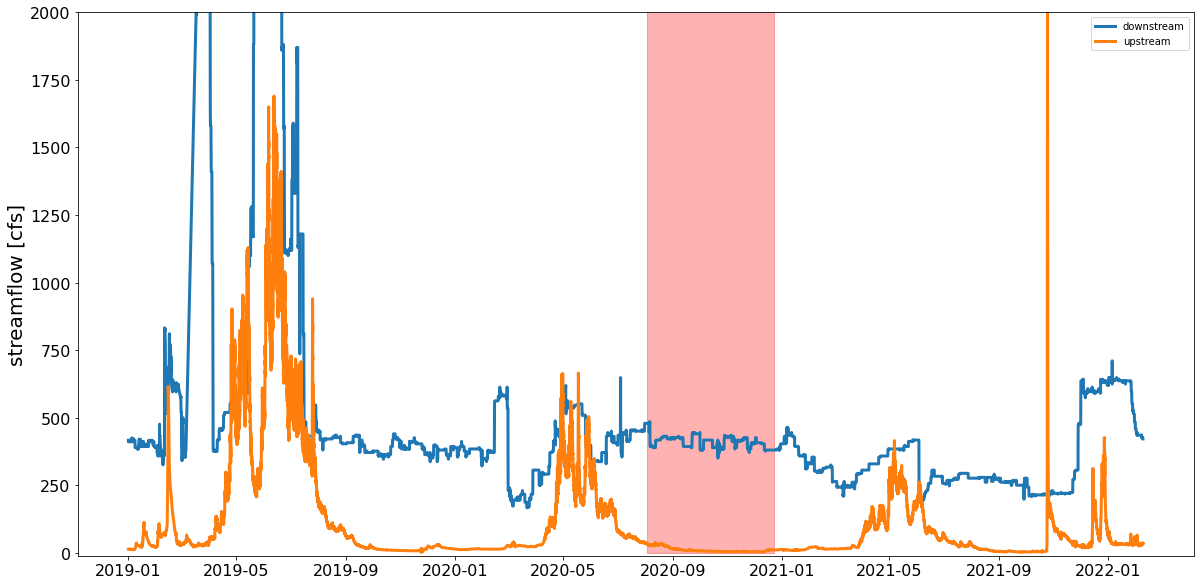

In [18]:
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(dt_down, df_downstream['streamflow'].values.astype('float'),'-',label = 'downstream')
xx =  [parser.parse(i) for i in data_upstream['datetime']]
yy = [float(d) for d in data_upstream['value']]
# ax.plot(dt_up, df_upstream['streamflow'].values.astype('float'),'-',label = 'upstream')
ax.plot(xx, yy,'-',label = 'upstream')

#ax2 = ax.twinx()
#ax2.plot(dt_down, df_downstream['temperature'].values.astype('float'),':',label = 'downstream')
#ax2.plot(dt_up,df_upstream['temperature'].values.astype('float'),':', label = 'upstream')
# ax.plot(dt_three, df_three.values.astype('float'),'-',label = 'three: 11303500')
# ax.plot(dt_four, df_four.values.astype('float'),'-',label = 'four: 11274000')
y =  df_upstream.values.astype('float').flatten()
ax.fill_betweenx([np.nanmin(y),7 * np.nanmax(y)],creek_start,creek_end,color='red',alpha = 0.3)
ax.set_ylim(-10,2000)
ax.legend()
# ax2.legend()
ax.set_ylabel('streamflow [cfs]')
plt.show()